In [61]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
# import openpyxl
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [62]:
data_original = pd.read_excel("loty_clean.xlsx")
data_original = pd.DataFrame(data_original)

In [68]:

def preprocess_flight_data(data):


    weekdays = {
        "Monday": [1, 0, 0, 0, 0, 0, 0],
        "Tuesday": [0, 1, 0, 0, 0, 0, 0],
        "Wednesday": [0, 0, 1, 0, 0, 0, 0],
        "Thursday": [0, 0, 0, 1, 0, 0, 0],
        "Friday": [0, 0, 0, 0, 1, 0, 0],
        "Saturday": [0, 0, 0, 0, 0, 1, 0],
        "Sunday": [0, 0, 0, 0, 0, 0, 1]
    }

    # konwersja daty
    data["Flight_date"] = pd.to_datetime(data["Flight_date"], format="%d.%m.%Y", errors="coerce")
    data["is_weekend"] = data["Flight_date"].dt.weekday >= 5

    # zakodowanie dni tygodnia na wektor
    data["Flight_weekday_vec"] = data["Flight_weekday"].map(weekdays)
    data["Extraction_Weekday_vec"] = data["Extraction_Weekday"].map(weekdays)

    flight_weekday_df = pd.DataFrame(data["Flight_weekday_vec"].tolist(),
                                     columns=["Flight_Mon","Flight_Tue","Flight_Wed","Flight_Thu","Flight_Fri","Flight_Sat","Flight_Sun"])
    extraction_weekday_df = pd.DataFrame(data["Extraction_Weekday_vec"].tolist(),
                                         columns=["Extract_Mon","Extract_Tue","Extract_Wed","Extract_Thu","Extract_Fri","Extract_Sat","Extract_Sun"])

    data = pd.concat([data, flight_weekday_df, extraction_weekday_df], axis=1)

    # usunięcie kolumn wektorowych
    data = data.drop(columns=["Flight_weekday", "Extraction_Weekday", "Flight_weekday_vec", "Extraction_Weekday_vec"])

    # --- Kodowanie lotnisk i klasy biletu ---
    data = pd.get_dummies(data, columns=["Departure_airport_code", "Destination_airport_code", "Ticket_class"], drop_first=True)

    # --- Przesiadki ---
    data["#Layovers"] = data["#Layovers"].astype(int)

    # czyszczenie czasu przesiadki - zamiana przecinka na kropkę i na float
    data["layover_duration"] = data["layover_duration"].astype(str).str.replace(",", ".").astype(float)
    data.loc[data["#Layovers"] == 0, "layover_duration"] = 0.0

    # lotnisko przesiadki - zastąp "-" "NONE"
    data["layover_airport"] = data["layover_airport"].replace("-", "NONE")
    data = pd.get_dummies(data, columns=["layover_airport"], prefix="layover", drop_first=True)

    # --- Linie lotnicze ---
    data["Airline2"] = data["Airline2"].replace("-", "NONE")
    data = pd.get_dummies(data, columns=["Airline1", "Airline2"], drop_first=True)

    # --- Low cost count ---
    data["low_cost_count"] = (data["low_cost1"] == "low-cost").astype(int) + (data["low_cost2"] == "low-cost").astype(int)
    data = data.drop(columns=["low_cost1", "low_cost2"])

    # --- Usuwamy kolumny, których nie chcemy w modelu ---
    data = data.drop(columns=["Extraction_Time", "Flight_date"])

    # --- Przygotowanie X i y ---
    X = data.drop(columns=["Price [PLN]"])
    y = data["Price [PLN]"]

    return X, y

data = data_original.copy()



X, y = preprocess_flight_data(data)
print(X.head())
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42)


   Departure_time  Arrival_time  Flight_time  #Layovers  Cabin_bag  \
0           16.58         17.92         1.33          0          1   
1           18.33         22.67         4.33          1          0   
2           19.67         21.00         1.33          0          1   
3            6.08         11.92         5.83          1          0   
4           17.00         22.67         5.67          1          1   

   Checked_bag  Days_to_departure  layover_duration  is_weekend  Flight_Mon  \
0            0                  2          0.000000       False           1   
1            0                  2          1.583333       False           1   
2            0                  2          0.000000       False           1   
3            0                  2          1.083333       False           1   
4            0                  2          2.833333       False           1   

   ...  Airline1_easyJet  Airline2_British Airways  Airline2_KLM  \
0  ...             False            

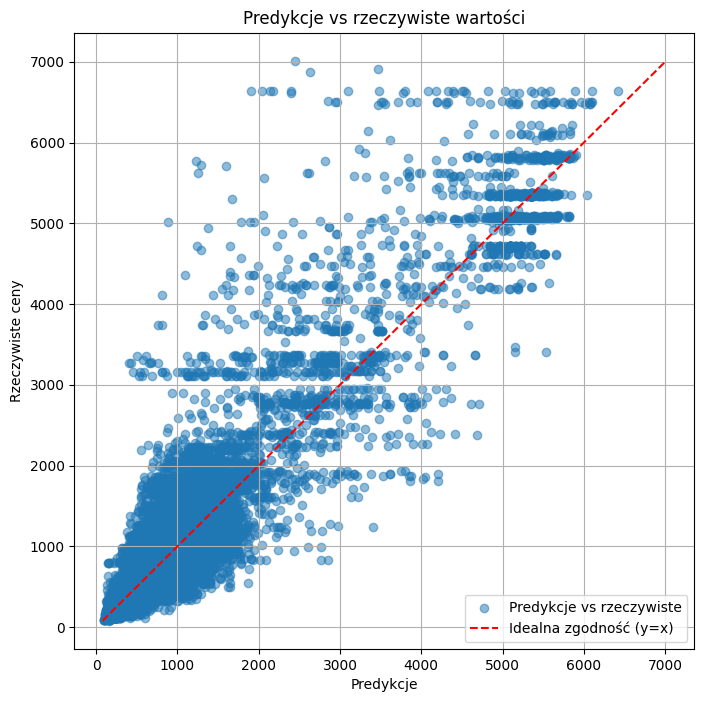

In [64]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:
mod = KNeighborsRegressor()


mod.fit(X_train, y_train)

pred_val = mod.predict(X_val)


plt.figure(figsize=(8, 8))
plt.scatter(pred_val, y_val, alpha=0.5, label="Predykcje vs rzeczywiste")

# Linia idealnej zgodności y=x
lims = [min(min(pred_val), min(y_val)), max(max(pred_val), max(y_val))]
plt.plot(lims, lims, 'r--', label='Idealna zgodność (y=x)')

plt.xlabel("Predykcje")
plt.ylabel("Rzeczywiste ceny")
plt.title("Predykcje vs rzeczywiste wartości")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mape = np.mean(abs((y_val - pred_val) / y_val))
r2 = r2_score(y_val, pred_val)

print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

RMSE: 357.62
R^2: 0.883
MAPE: 0.22


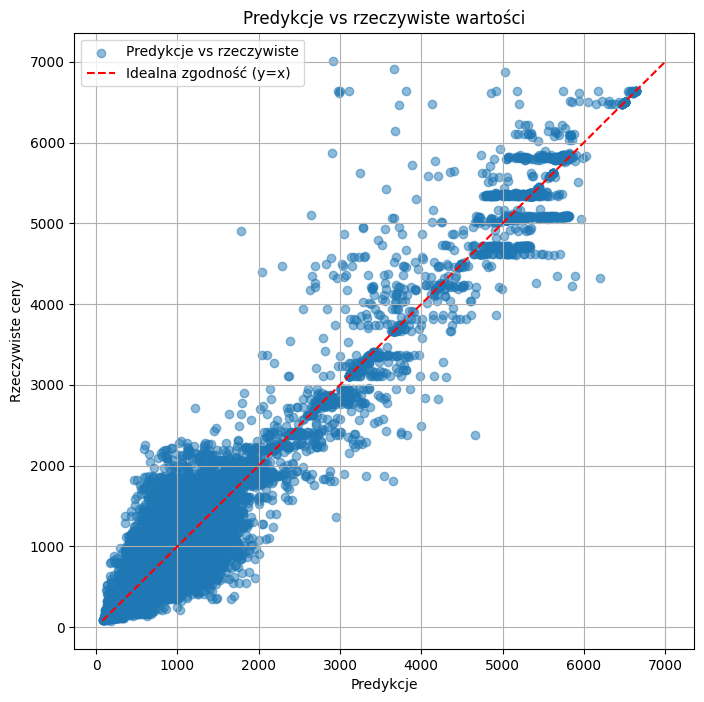

In [66]:

mod = RandomForestRegressor()


mod.fit(X_train, y_train)


pred_val = mod.predict(X_val)

plt.figure(figsize=(8, 8))
plt.scatter(pred_val, y_val, alpha=0.5, label="Predykcje vs rzeczywiste")

lims = [min(min(pred_val), min(y_val)), max(max(pred_val), max(y_val))]
plt.plot(lims, lims, 'r--', label='Idealna zgodność (y=x)')

plt.xlabel("Predykcje")
plt.ylabel("Rzeczywiste ceny")
plt.title("Predykcje vs rzeczywiste wartości")
plt.legend()
plt.grid(True)
plt.show()


In [67]:
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mape = np.mean(abs((y_val - pred_val) / y_val))
r2 = r2_score(y_val, pred_val)

print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

RMSE: 242.54
R^2: 0.946
MAPE: 0.17
